In [25]:
%load_ext autoreload
%autoreload 1
%aimport pygenesig.file_formats
%aimport pygenesig.visualization

from pygenesig.file_formats import *
from pygenesig.bioqc import BioQCSignatureTester
from pygenesig.tools import *
from pygenesig.visualization import * 

from pylab import * 
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Run GTEx v6 signatures on mouseGNF samples

In [2]:
gtex_sig = load_gmt("../results/gtex_v6_gini_0.8_3/signatures.gmt")

## load mouseGNF data

In [8]:
m_expr = read_expr("../data_processed/mouseGNF/exprs.npy")
m_rosetta_inv = read_rosetta("../data_processed/mouseGNF/rosetta.csv", inverse=True)
m_target = read_target("../data_processed/mouseGNF/target.csv")

In [84]:
m_expr.shape, m_target.shape

((15851, 160), (160,))

### Translate the signature names from mouseGNF 
For a better overview in the heatmap, we map the names from the mouseGNF dataset to the equivalent names
in the gtex signatures. This was done manually in an excel sheet.
* Tissue names are mapped to an equivalent name
* Tissues/Cell types which do not appear in the GTEx signatures are excluded. 

In [45]:
m_target_map = pd.read_csv("../manual_annotation/mouseGNF_map_tissues.csv", sep=";", header=None)

In [48]:
target_dict = dict(zip(m_target_map[0], m_target_map[1]))

In [68]:
m_target_new = pd.Series([target_dict[t] for t in m_target])

In [69]:
m_expr_new = m_expr[:, ~m_target_new.isnull().values]
m_target_new = m_target_new[~m_target_new.isnull()].values

In [70]:
m_expr_new.shape, m_target_new.shape

((15851, 60), (60,))

### Translate signatures to index of gene expression matrix
We need to transform the gene symbols in the gtex-signatures to
the indices of the gene expression matrix of mouseGNF

In [76]:
gtex_sig_ind = translate_signatures(gtex_sig, m_rosetta_inv, ignore_missing=True)

## run BioQC

In [78]:
st = BioQCSignatureTester(m_expr_new, m_target_new)

In [79]:
scores = st.score_signatures(gtex_sig_ind)

### Visualize the score matrix
Clustermap of the BioQC-scores. BioQC scores exceeding 10 are clipped. 

In [82]:
score_mat = aggregate_scores(st.sort_signatures(gtex_sig_ind), scores, m_target_new)

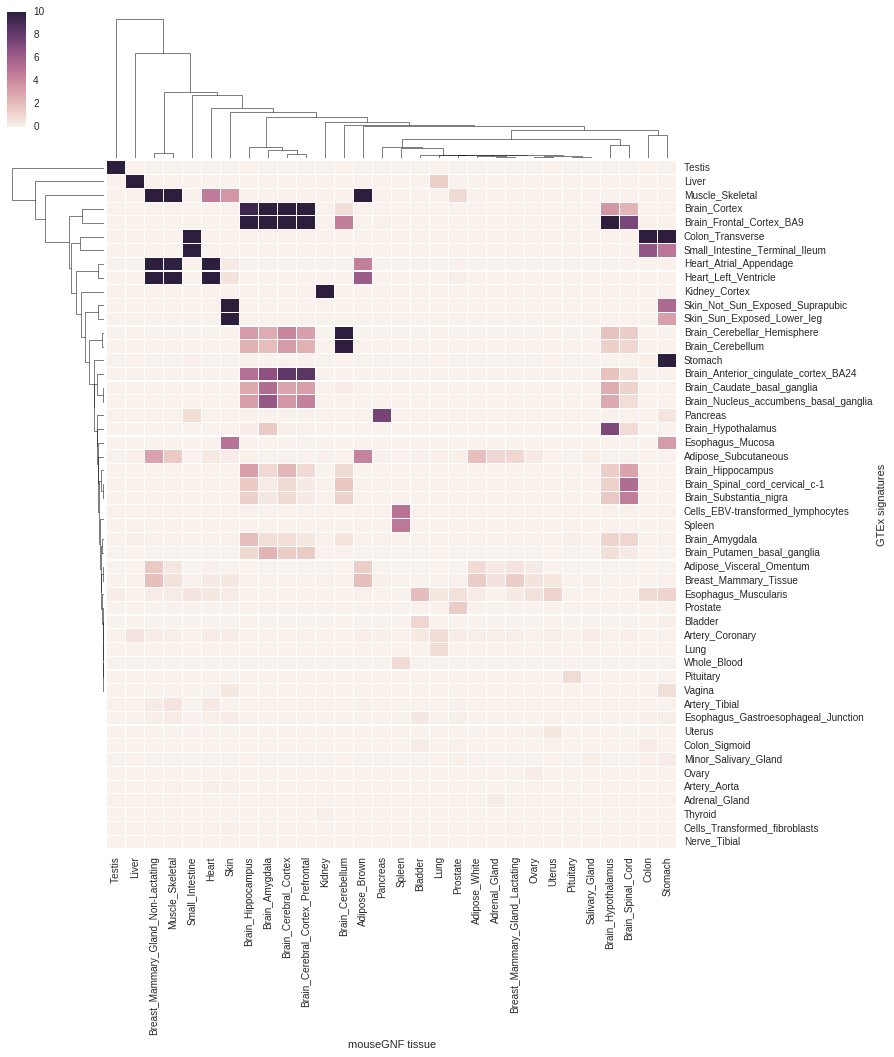

In [87]:
g = sns.clustermap(score_mat, linewidths=.2, figsize=heatmap_figsize(score_mat.shape[0], score_mat.shape[1]), vmax=10)
ax = g.ax_heatmap
plt.setp(ax.get_yticklabels(), rotation=0);
ax.set_ylabel("GTEx signatures")
ax.set_xlabel("mouseGNF tissue")